# ✅ Objetivo: Predecir el tiempo que tomará resolver una orden de trabajo

In [41]:
import pandas as pd
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Preparar datos

In [42]:
df_trabajos = pd.read_csv('../datasets/trabajos.csv')
df_trabajo_empleados = pd.read_csv('../datasets/trabajo_empleados.csv')

In [64]:
df_trabajos

,id,reporte_id,tipo_trabajo,descripcion,prioridad,materiales,observaciones_materiales,created_at,updated_at,tiempo_resolucion
0,1,1,reparacion,Es necesario reparar el sistema dañado,urgente,Modem Huawei,NaN,2023-01-01 03:51:00,2023-01-02 18:51:00,39.0
1,2,2,instalacion,Hay que ir a instalar una nueva conexión,baja,NaN,Verificar stock en bodega,2023-01-01 17:32:00,2023-01-04 16:32:00,71.0
2,3,3,mantenimiento,Realizar mantenimiento preventivo,normal,Antena de 5GHz,NaN,2023-01-04 01:45:00,2023-01-04 06:45:00,5.0
3,4,4,instalacion,Hay que ir a instalar una nueva conexión,normal,NaN,Verificar stock en bodega,2023-01-06 07:53:00,2023-01-07 06:53:00,23.0
4,5,5,mantenimiento,Realizar mantenimiento preventivo,urgente,Antena de 5GHz,Verificar stock en bodega,2023-01-07 09:55:00,2023-01-07 12:55:00,3.0
...,...,...,...,...,...,...,...,...,...,...
2017,2018,2018,mantenimiento,Realizar mantenimiento preventivo,normal,Modem Huawei,Verificar stock en bodega,2025-06-17 03:24:00,2025-06-19 13:24:00,58.0
2018,2019,2019,configuracion,Configurar nuevamente el equipo,alta,"Router TP-Link, Cable UTP",Verificar stock en bodega,2025-06-21 07:19:00,2025-06-22 23:19:00,40.0
2019,2020,2020,instalacion,Hay que ir a instalar una nueva conexión,normal,Antena de 5GHz,Verificar stock en bodega,2025-06-17 13:26:00,2025-06-19 14:26:00,49.0
2020,2021,2021,configuracion,Configurar nuevamente el equipo,alta,"Router TP-Link, Cable UTP",NaN,2025-06-21 07:31:00,2025-06-23 17:31:00,58.0


In [69]:
df_prediccion = pd.DataFrame()
df_prediccion

In [65]:
# Convertir fechas y calcular el tiempo de resolución en horas
df_trabajos['created_at'] = pd.to_datetime(df_trabajos['created_at'], errors='coerce')
df_trabajos['updated_at'] = pd.to_datetime(df_trabajos['updated_at'], errors='coerce')
df_trabajos['tiempo_resolucion'] = (df_trabajos['updated_at'] - df_trabajos['created_at']).dt.total_seconds() / 3600

In [66]:
# Eliminar registros con datos faltantes
df_trabajos.dropna(subset=['tiempo_resolucion'], inplace=True)

# 2. Extraer número de empleados por trabajo

In [45]:
empleados_por_trabajo = (
    df_trabajo_empleados
    .groupby('trabajo_id')
    .size()
    .reset_index(name='cantidad_empleados')
)

In [46]:
df_modelo = df_trabajos.merge(empleados_por_trabajo, left_on='id', right_on='trabajo_id', how='left')
df_modelo['cantidad_empleados'] = df_modelo['cantidad_empleados'].fillna(0)

# 3. Crear columnas categóricas (One-Hot Encoding)

In [47]:
features = ['tipo_trabajo', 'prioridad', 'cantidad_empleados']
X = df_modelo[features]
y = df_modelo['tiempo_resolucion']

In [48]:
# One-Hot Encoding para variables categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X[['tipo_trabajo', 'prioridad']])
X_encoded = np.hstack([X_cat, X[['cantidad_empleados']].values])

# 4. Dividir datos

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1617, 7), (405, 7), (1617,), (405,))

# 5. Modelo de regresión lineal

In [50]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

# 6. Evaluación

In [51]:
y_pred = modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [52]:
print(f"RMSE: {rmse:.2f} horas")

RMSE: 21.25 horas


# 7. Ejemplo de predicción

In [53]:
# tipo_trabajo='instalacion', prioridad='alta', cantidad_empleados=3
ejemplo_input = pd.DataFrame([{
    'tipo_trabajo': 'instalacion',
    'prioridad': 'alta',
    'cantidad_empleados': 3
}])

In [54]:
ejemplo_cat = encoder.transform(ejemplo_input[['tipo_trabajo', 'prioridad']])
ejemplo_encoded = np.hstack([ejemplo_cat, ejemplo_input[['cantidad_empleados']].values])
prediccion = modelo.predict(ejemplo_encoded)

In [55]:
print(f"Tiempo estimado de resolución: {prediccion[0]:.2f} horas")

Tiempo estimado de resolución: 36.15 horas


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

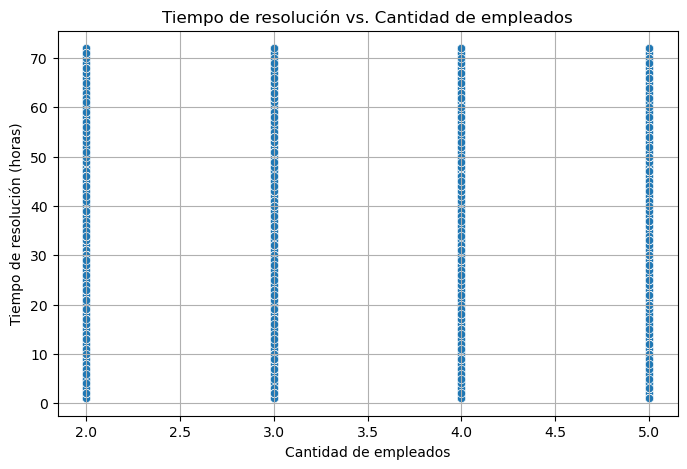

In [57]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_modelo, x='cantidad_empleados', y='tiempo_resolucion')
plt.title('Tiempo de resolución vs. Cantidad de empleados')
plt.xlabel('Cantidad de empleados')
plt.ylabel('Tiempo de resolución (horas)')
plt.grid(True)
plt.show()

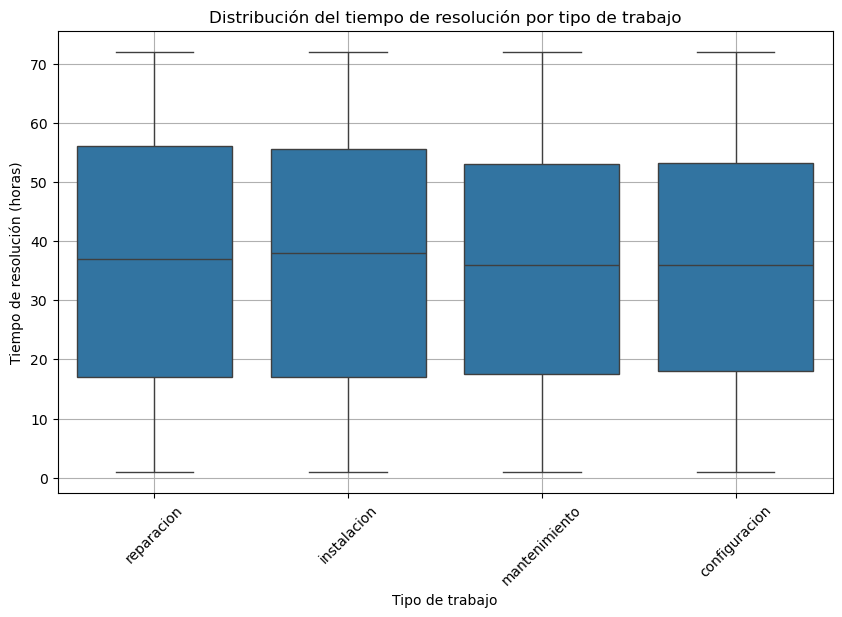

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_modelo, x='tipo_trabajo', y='tiempo_resolucion')
plt.title('Distribución del tiempo de resolución por tipo de trabajo')
plt.xlabel('Tipo de trabajo')
plt.ylabel('Tiempo de resolución (horas)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

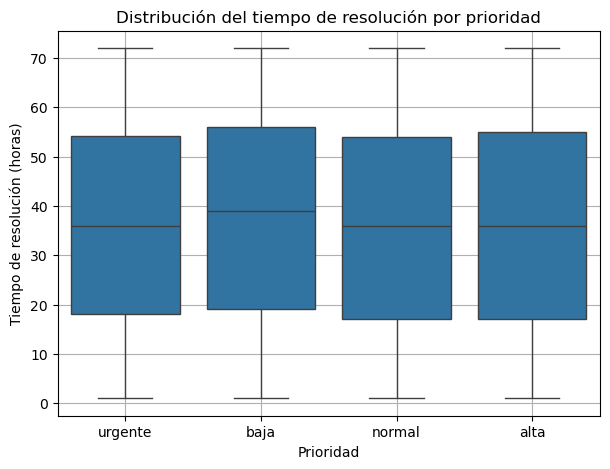

In [59]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_modelo, x='prioridad', y='tiempo_resolucion')
plt.title('Distribución del tiempo de resolución por prioridad')
plt.xlabel('Prioridad')
plt.ylabel('Tiempo de resolución (horas)')
plt.grid(True)
plt.show()

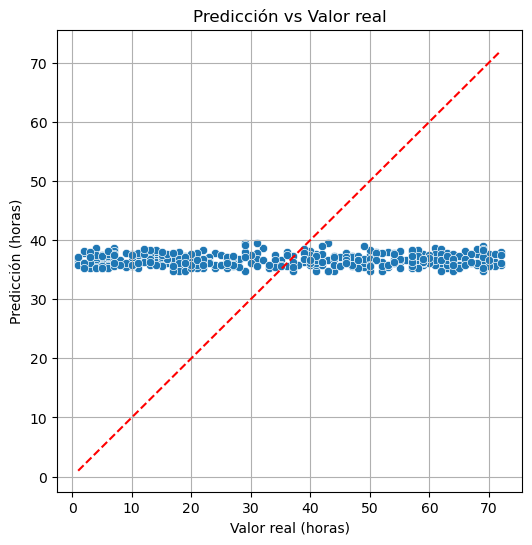

In [60]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Predicción vs Valor real')
plt.xlabel('Valor real (horas)')
plt.ylabel('Predicción (horas)')
plt.grid(True)
plt.show()

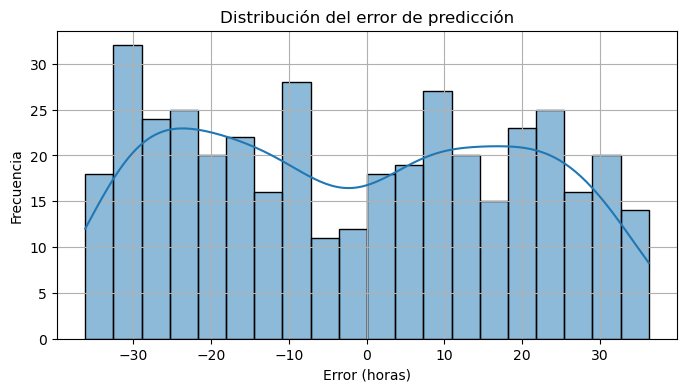

In [61]:
errores = y_test - y_pred

plt.figure(figsize=(8, 4))
sns.histplot(errores, bins=20, kde=True)
plt.title('Distribución del error de predicción')
plt.xlabel('Error (horas)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()